Prepared by: Maria Stoica  
Last Updated: 2 March 2017  
## 1. Preparing the workspace.

Load necessary packages.

In [30]:
## topoflow
import topoflow
# short name alias to initiate TopoFlow run
topo_run = topoflow.topoflow.framework.tests.test_framework.topoflow_test
#NumPy for decimal ranges
import numpy as np
#SciPy for evaluating Gamma function
import scipy as sp
#os and errno for creating output directories
import os
import errno
from shutil import copyfile
#plotting functions
import matplotlib.pyplot as plt
#for text wrap of long titles
from textwrap import wrap
#datetime to check data availability
import datetime
#Pandas for data frames and data manipulation
import pandas as pd
# For moving the legend.
from matplotlib.font_manager import FontProperties

#this line is necessary for plotting in iPython notebook
%matplotlib inline

Set up the directory paths:

In [31]:
#### Set directory paths, our output path is absolute at the moment, you will need to change this to your outputpath
input_path = 'C2-input-files/'
default_file_path = 'default-input-files/'
channels_filename = 'channels_kinematic_wave.cfg'
infil_filename = 'infil_green_ampt.cfg'
topodriver_filename = 'topoflow.cfg'
meteorology_filename_2s = 'meteorology_2s.cfg'
meteorology_filename_hr = 'meteorology_hr.cfg'
path_info = 'path_info.cfg'
base_components_2s = [channels_filename, topodriver_filename, meteorology_filename_2s, path_info]
base_components_hr = [channels_filename, topodriver_filename, meteorology_filename_hr, path_info]
output_path = 'simulation-results/'

Define a function to create directories for output files as needed:

In [32]:
def create_path(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

Define a function to set the output path in the enabled configuration files.

In [33]:
def create_cfg(filename,run):
    f = open(default_file_path+filename,'r')
    info = f.read()
    f.close()
    info = info.replace('~/TF_Output/C2',run)
    f = open(input_path+'Test1_'+filename.replace('_2s','').replace('_hr',''),'w')
    f.write(info)
    f.close()

Define a function to create the infiltration input file by plugging in the desired parameter values.

In [34]:
def create_infil_cfg(infil_filename,run,Ksat,theta_i,G):
    f = open(default_file_path+infil_filename,'r')
    info = f.read()
    f.close()
    
    #theta_e and Ki computed from theta_i, theta_sat, Ksat
    theta_e = theta_i/theta_sat
    Ki = Ksat*theta_e**(eta/lambda_table)
    #info=info.replace('~/TopoFlow_Runs/Caribou/C2',run)
    info=info.replace('Ks[0]               | 3.5e-7        | ',\
        'Ks[0]               | '+str(Ksat)+'       | ')
    info=info.replace('Ki[0]               | 6.0e-8        | ',\
        'Ki[0]               | '+str(Ki)+'        | ')
    info=info.replace('qi[0]               | 0.10          | ',\
        'qi[0]               | '+str(theta_i)+'          | ')
    info=info.replace('G[0]                | 0.724         | ',\
        'G[0]                | '+str(G)+'         | ')
    
    f = open(input_path+'Test1_'+infil_filename,'w')
    f.write(info)
    f.close()

Define a function to disable the infiltration component.

In [35]:
def disable_infil_cfg(infil_filename):
    f = open(default_file_path+infil_filename,'r')
    info = f.read()
    f.close()
            
    info=info.replace('Enabled','Disabled')
    
    f = open(input_path+'Test1_'+infil_filename,'w')
    f.write(info)
    f.close()

Define a function to clean up after a run -- delete unwanted files and copy over the infiltration cfg to help keep track of the parameter settings for the run.

In [36]:
def post_run_cleanup(run):
    try:
        os.remove(run+'/Test1_0D-Q.nc')
    except:
        print 'Test1_0D-Q_1.nc not removed!'
    try:
        os.remove(run+'/Test1_2D-Q.bov')
    except:
        print 'Test1_2D-Q_1.bov not removed!'
    try:
        os.remove(run+'/Test1_2D-Q.nc')
    except:
        print 'Test1_2D-Q_1.nc not removed!'
    try:
        os.remove(run+'/Test1_2D-Q.rti')
    except:
        print 'Test1_2D-Q_1.rti not removed!'
    try:
        os.remove(run+'/Test1_2D-Q.rts')
    except:
        print 'Test1_2D-Q_1.rts not removed!'
    copyfile(input_path+'Test1_'+infil_filename,\
                run+'/Test1_'+infil_filename)

Define a function to create and display a plot of measured and computed discharge.

In [37]:
def plot_discharge_comparison(run):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    
    temp=pd.read_csv(run+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)

    # plot the observed and computed discharges
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,flow_data['Flow']*.001, 'g-')
    ax2.plot(temp[0]/60/24,temp[1], 'b-')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('observed discharge rate (m$^3$/s)', color='g')
    ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='b')
    plt.title("\n".join(wrap('C2 observed and computed discharges', 60)))
    plt.show()

Define a function to plot multiple discharge curves.

In [38]:
def plot_discharge_comparison_multiple(path,runs,x_range=None,y_range=None):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    
    # plot the observed and computed discharges
    fig, ax1 = plt.subplots()
    if x_range is None:
        ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,flow_data['Flow']*.001, 'k-',label='observed')
        ax1.set_ylabel('observed discharge rate (m$^3$/s)', color='k')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')

    ax2 = ax1.twinx()
    if not(x_range is None):
        ax2.set_xticks(x_range)
    if not(y_range is None):
        ax2.set_yticks(y_range)
    color_cycle=['r', 'g', 'b', 'y']
    line_cycle = ['-', '--', ':', '-.']
    
    for x in range(len(runs)):
        temp=pd.read_csv(path+runs[x]+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
        ax2.plot(temp[0]/60/24,temp[1],color_cycle[x%4]+line_cycle[x/4],label=runs[x])
        ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='k')
    if not (x_range is None):
        plt.xlim([min(x_range),max(x_range)])
    if not (y_range is None):
        plt.ylim([min(y_range),max(y_range)])
    plt.title("\n".join(wrap('C2 observed and computed discharges', 60)))
    plt.legend()
    plt.show()

The following two functions do the same as the previous, except they generates specific eps plots for the paper.

In [39]:
def plot_discharge_comparison_multiple_eps(path,runs,epsname,suf,x_range=None,y_range=None):
    fontP = FontProperties()
    fontP.set_size('small')
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    
    # plot the observed and computed discharges
    fig, ax1 = plt.subplots()
    if x_range is None:
        ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,flow_data['Flow']*.001, 'k-',label='observed')
        ax1.set_ylabel('observed discharge rate (m$^3$/s)', color='k')
    else:
        ax1.get_yaxis().set_visible(False)
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')

    ax2 = ax1.twinx()
    ax2.get_yaxis().set_visible(True)
    
    if not(x_range is None):
        ax2.set_xticks(x_range)
    if not(y_range is None):
        ax2.set_yticks(y_range)
    color_cycle=['r', 'g', 'b', 'y']
    line_cycle = ['-', '--', ':', '-.']
    
    for x in range(len(runs)):
        temp=pd.read_csv(path+runs[x]+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
        if suf!='':
            ax2.plot(temp[0]/60/24,temp[1],color_cycle[x%4]+line_cycle[x/4],label='$'+runs[x]\
                .replace('Ks','Ks = ').replace('en',' x 10^{-').replace('p','.')\
                .replace('G','G = ')+suf+'$')
        else:
            ax2.plot(temp[0]/60/24,temp[1],color_cycle[x%4]+line_cycle[x/4])
    if suf!='':
        ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='k')
    else:
        ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='r')
    if not (x_range is None):
        plt.xlim([min(x_range),max(x_range)])
    if not (y_range is None):
        plt.ylim([min(y_range),max(y_range)])
    if suf!='':
        plt.legend(prop=fontP)
    plt.savefig(epsname,format='eps',dpi=1000)
    

In [40]:
def plot_discharge_comparison_multiple_eps2(path,runs,epsname):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    
    # plot the observed and computed discharges
    fig, ax1 = plt.subplots()
    ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,flow_data['Flow']*.001, 'k-',label='observed')
    ax1.set_ylabel('observed discharge rate (m$^3$/s)', color='k')
    ax1.set_ylim([0.035,0.22])
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')

    ax2 = ax1.twinx()
    color_cycle=['r', 'g', 'b', 'y']
    line_cycle = ['-', '--', ':', '-.']
    
    for x in range(len(runs)):
        temp=pd.read_csv(path+runs[x]+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
        ax2.plot(temp[0]/60/24,temp[1]+0.037,color_cycle[x%4]+line_cycle[x/4])
    ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='r')
    ax2.set_ylim([0.035,0.22])
    plt.savefig(epsname,format='eps',dpi=1000)

Define a function to create and display a plot of measured and computed cumulative discharge.

In [41]:
def plot_cumulative_discharge_comparison(run):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    temp=pd.read_csv(run+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)

    baseflow = 0.037 #m3/s
    # Function that integrates discrete function at each point using np.trapz()
    def int_fun(y,dx):
        int_y = np.zeros(len(y))
        for dy in range(1,len(y)):
            int_y[dy] = np.trapz(y[:dy],dx = dx)
        return int_y

    # plot the cumulative discharges
    int_obs_discharge = int_fun(flow_data['Flow']*.001-baseflow,15*60)
    int_comp_discharge = int_fun(temp[1],60)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,\
        int_obs_discharge, 'g-')
    ax2.plot(temp[0]/60/24,int_comp_discharge, 'b-')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('cumulative observed discharge (m$^3$)', color='g')
    ax2.set_ylabel('cumulative computed discharge (m$^3$)', color='b')
    plt.title("\n".join(wrap('C2 observed and computed cumulative discharges', 60)))
    plt.show()

Define a function to plot the computed discharge alongside the precipiation peaks.

In [42]:
def plot_precip_discharge_comparison(run):
    try:
        precip_data = pd.read_csv('precipitation/precip_cpeak_slice.csv')
    except:
        print 'File not present. Please put precip_cpeak_slice.csv in precipitation folder.'
        return
    temp=pd.read_csv(run+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(precip_data['time-seconds']/3600/24-time_min/3600/24,\
        #precip_data['cpeak_value']*4.83503*10**3/3600, 'g-',linewidth=3)
        precip_data['cpeak_value'], 'g-',linewidth=3)
    ax2.plot(temp[0]/60/24,temp[1], 'b--')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('observed precipitation rate (mm/hr)', color='g')
    ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='b')
    plt.title("\n".join(wrap('C2 cumulative precipitation and computed discharges', 60)))
    plt.show()

Define a function to plot the cumulative precipitation vs the discharge response.

In [43]:
def plot_cumulative_precip_discharge_comparison(run):
    try:
        precip_data = pd.read_csv(input_path + 'Test1_precip_CPEAK.txt',header=None)
    except:
        print 'File not present. Please put Test1_precip_CPEAK.txt in input folder.'
        return
    temp=pd.read_csv(run+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
    
    # Function that integrates discrete function at each point using np.trapz()
    def int_fun(y,dx):
        int_y = np.zeros(len(y))
        for dy in range(1,len(y)):
            int_y[dy] = np.trapz(y[:dy],dx = dx)
        return int_y
    
    precip_int=int_fun(precip_data[0]/3600,2)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(np.arange(0,91800*2.0/3600/24,2.0/3600/24),\
        #precip_data['cpeak_value']*4.83503*10**3/3600, 'g-',linewidth=3)
        precip_int/1000, 'g-',linewidth=3)
    ax2.plot(temp[0]/60/24,temp[1], 'b--')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('cumulative precipitation (m)', color='g')
    ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='b')
    plt.title("\n".join(wrap('C2 cumulative precipitation and computed discharges', 60)))
    plt.show()

This function does the same as the previous, except it formats the plot slightly differently and saves it to eps format for the paper.

In [44]:
def plot_cumulative_precip_discharge_comparison_eps(run,epsname):
    try:
        precip_data = pd.read_csv(input_path + 'Test1_precip_CPEAK.txt',header=None)
    except:
        print 'File not present. Please put Test1_precip_CPEAK.txt in input folder.'
        return
    temp=pd.read_csv(run+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
    
    # Function that integrates discrete function at each point using np.trapz()
    def int_fun(y,dx):
        int_y = np.zeros(len(y))
        for dy in range(1,len(y)):
            int_y[dy] = np.trapz(y[:dy],dx = dx)
        return int_y
    
    precip_int=int_fun(precip_data[0]/3600,2)
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.plot(np.arange(0,91800*2.0/3600/24,2.0/3600/24),\
        #precip_data['cpeak_value']*4.83503*10**3/3600, 'g-',linewidth=3)
        precip_int, 'g-',linewidth=3)
    ax2.plot(temp[0]/60/24,temp[1], 'b--')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('cumulative precipitation (mm)', color='g')
    ax2.set_ylabel('computed discharge rate (m$^3$/s)', color='b')
    plt.savefig(epsname,format='eps',dpi=1000)

Define a function to plot the cumulative total discharge as a function of a parameter (G). The subsequent function generates the plot with specific formatting for the paper.

In [45]:
def plot_total_discharge(path,runs):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    
    baseflow = 0.037 #m3/s
    # Function that integrates discrete function at each point using np.trapz()
    def int_fun(y,dx):
        int_y = np.zeros(len(y))
        for dy in range(1,len(y)):
            int_y[dy] = np.trapz(y[:dy],dx = dx)
        return int_y

    int_obs_discharge = int_fun(flow_data['Flow']*.001-baseflow,15*60)
    # plot the observed and computed discharges
    fig, ax1 = plt.subplots()
    ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,\
        int_obs_discharge, 'k-',label='observed')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('cumulative observed discharge (m$^3$)', color='k')
    ax2 = ax1.twinx()
    color_cycle=['r', 'g', 'b', 'y']
    line_cycle = ['-', '--', ':', '-.']
    
    for x in range(len(runs)):
        temp=pd.read_csv(path+runs[x]+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
        int_comp_discharge = int_fun(temp[1],60)
        ax2.plot(temp[0]/60/24,int_comp_discharge,color_cycle[x%4]+line_cycle[x/4],label=runs[x])
        ax2.set_ylabel('cumulative computed discharge (m$^3$)', color='k')
    plt.title("\n".join(wrap('C2 cumulative observed and computed discharges', 60)))
    plt.legend()
    plt.show()

In [46]:
def plot_total_discharge_eps(path,runs,epsname):
    try:
        flow_data = pd.read_csv('discharges/flow_data_slice.csv')
    except:
        print 'File not present. Please put flow_data_slice.csv in discharges folder.'
        return
    
    baseflow = 0.037 #m3/s
    # Function that integrates discrete function at each point using np.trapz()
    def int_fun(y,dx):
        int_y = np.zeros(len(y))
        for dy in range(1,len(y)):
            int_y[dy] = np.trapz(y[:dy],dx = dx)
        return int_y

    int_obs_discharge = int_fun(flow_data['Flow']*.001-baseflow,15*60)
    # plot the observed and computed discharges
    fig, ax1 = plt.subplots()
    ax1.plot(flow_data['time-seconds']/3600/24-time_min/3600/24,\
        int_obs_discharge, 'k-',label='observed')
    ax1.set_xlabel('time (days after start date 2008/07/28 16:00:00)')
    ax1.set_ylabel('cumulative observed discharge (m$^3$)', color='k')
    ax2 = ax1.twinx()
    color_cycle=['r', 'g', 'b', 'y']
    line_cycle = ['-', '--', ':', '-.']
    
    for x in range(len(runs)):
        temp=pd.read_csv(path+runs[x]+'/Test1_0D-Q.txt',header=None,skiprows=2,delim_whitespace=True)
        int_comp_discharge = int_fun(temp[1],60)
        ax2.plot(temp[0]/60/24,int_comp_discharge,color_cycle[x%4]+line_cycle[x/4])
    ax2.set_ylabel('cumulative computed discharge (m$^3$)', color='r')
    plt.savefig(epsname,format='eps',dpi=1000)

## 2. Set up parameter inputs.

These are the parameters needed for the infiltration process.

In [47]:
lambda_table = 0.189
G_table = 0.724 # m, cappilary length scale from table
theta_sat = 0.205 # saturated water content
psi_B = -0.786 # m, bubbling pressure head
eta = 2+3*lambda_table
c = eta/lambda_table
f1 = 1+1/c
f2 = (eta-1)/c
# m, capillary length scale, transitional Brooks-Corey
# G_tBC = -psi_B*sp.special.gamma(f1)*sp.special.gamma(f2)/sp.special.gamma(lambda_table) 
# special not working at the moment, so here is the value
G_tBC = 1.271863334375879

# These are the values that we will play around with, but for now we initialize them:
G = G_table #m
Ksat = 5*10**-7 #m/s
theta_i = 0.18

#### Set start and end times for desired data chunk
time_min=(datetime.datetime.strptime('2008/07/28  16:00:00',\
    '%Y/%m/%d %H:%M:%S')-datetime.datetime(1970,1,1)).total_seconds()

## 3. Run TopoFlow

### Run 1. No infiltration.

For the first run, we will turn on the meteorology, topoflow, and kinematic wave components. The meteorology component will take precipitation as an input.

First, we need to create the input files.

In [48]:
run='no_infiltration'
create_path(output_path+run)
for filename in base_components_hr:
    create_cfg(filename,output_path+run)

For this run only, we need to disable the infiltration component.

In [49]:
disable_infil_cfg(infil_filename)

Now we run the simulation. If you would like to execute this step, take out the comment on the next two lines. Run time on a typical machine is about 10-20 minutes. Otherwise, for this and future runs we have provided the output files so you may visualize them directly.

In [50]:
%%capture
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)

In [51]:
#post_run_cleanup(output_path+run)

Let's visualize what we just ran.

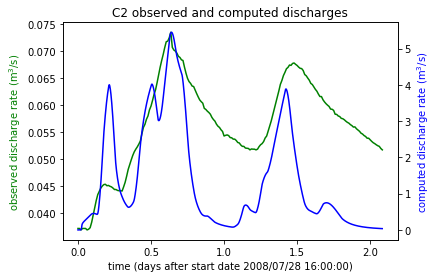

In [52]:
plot_discharge_comparison(output_path+run)

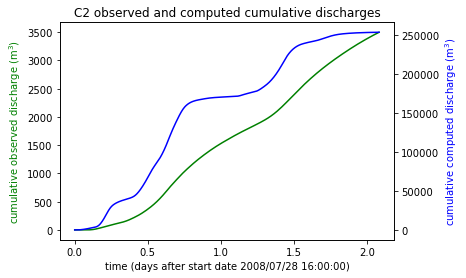

In [53]:
plot_cumulative_discharge_comparison(output_path+run)

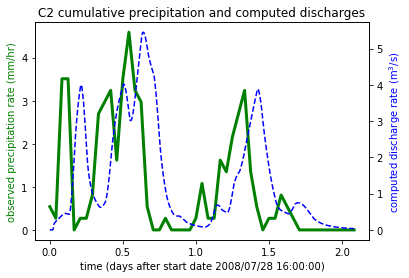

In [54]:
plot_precip_discharge_comparison(output_path+run)

Also, let's look at the log file which gives us a summary of the run, including the total precipitation volume as well as the total discharge volume.

In [55]:
with open(output_path+run+'/Test1.log', 'r') as fin:
    print fin.read()

------------------------------------------------------------
TopoFlow Version 3.5 (2/20/17)
Mon Feb 27 09:42:04 2017
 
Input directory:      C2-input-files/\
Output directory:     simulation-outputs/no_infiltration_d8ts2\
Site prefix:          C2
Case prefix:          Test1
 
Simulated time:      3000.0 [min]
Program run time:    15.7222666661 [min]
 
Number of timesteps: 90000
Number of columns:   233
Number of rows:      113
 
T_stop:            3000.0 [min]
 
Main outlet ID:    (101, 124) (row, col)
Basin_area:        4.83503 [km^2] 
 
Min Manning's n:   0.0131894815713
Max Manning's n:   0.300035893917
 
Q_final:           0.035514166034 [m^3/s]
Q_peak:            5.45094871917 [m^3/s]
Q_peak_time:       921.433333333 [min]
u_peak:            3.89407656555 [m/s]
u_peak_time:       921.4 [min]
d_peak:            0.208893115468 [m]
d_peak_time:       921.4 [min]
 
Max(precip rate):  4.59000015259 [mm/hr]
 
Total accumulated volumes over entire DEM:
vol_P   (rainfall):      556173.730

From the output file above, we see that at the end of the simulation, there is a large volume of water (~300000 m^3) that drains out from adjacent watersheds. We also see that the discharge curve mirrors the precipitation curve. From the discharge comparison plot, we note the following: (a) the response to the second and third precipitation peaks blend together so that the second peak becomes a shoulder of the third peak in the observations, (b) the precipitation response and discharge decay rate the the simulation are much more rapid than the observed, and (c) if we name the peaks A, B, and C, where A is the discharge response to the first precipitation peak, B is the combined response to the second and third precipitation peaks, and C is the response to the last precipitation peak, then the ratio of peak A to peak B is much smaller in the observed versus the simulated response, while the ratio of peak C to B is approximately 3.5/5 in the simulation and 1/2 in the observed data. Therefore, attenuation in the observed data is most significant for the first peak, followed by the last peak. 

Now, let's check the total precipitated volume.

In [56]:
try:
    precip_data = pd.read_csv('precipitation/CPEAK_precip_values.csv',header=None)
except:
    print 'File not present. Please put CPEAK_precip_values.csv in precipitation folder.'
DEM_area = 10618055.032269835#m^3
precip_volume = sum(precip_data[0]/1000)*DEM_area
print 'vol_P is '+str(precip_volume)+' m^3'
print 'Difference between observed and computed vol_P is '+str(556173.730134-precip_volume)+' m^3'

vol_P is 550439.972873 m^3
Difference between observed and computed vol_P is 5733.75726113 m^3


Let's run the same run with a new precipitation file where precipitation data is uniformly distributed but is subsampled every 2 seconds instead of once an hour.

In [57]:
%%capture
run='no_infiltration_subsamp_2s'
create_path(output_path+run)
for filename in base_components_2s:
    create_cfg(filename,output_path+run)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(output_path+run)

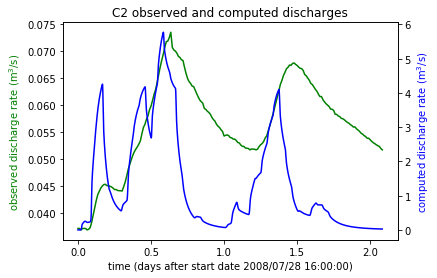

In [58]:
plot_discharge_comparison(output_path+run)

In [59]:
with open(output_path+run+'/Test1.log', 'r') as fin:
    print fin.read()

------------------------------------------------------------
TopoFlow Version 3.5 (2/20/17)
Wed Mar 01 19:41:31 2017
 
Input directory:      C2-input-files/\
Output directory:     simulation-outputs/no_infiltration_subsamp_2s\
Site prefix:          C2
Case prefix:          Test1
 
Simulated time:      3000.0 [min]
Program run time:    107.296999999 [min]
 
Number of timesteps: 90000
Number of columns:   233
Number of rows:      113
 
T_stop:            3000.0 [min]
 
Main outlet ID:    (101, 124) (row, col)
Basin_area:        4.83503 [km^2] 
 
Min Manning's n:   0.0131894815713
Max Manning's n:   0.300035893917
 
Q_final:           0.025494225686 [m^3/s]
Q_peak:            5.77394322547 [m^3/s]
Q_peak_time:       841.766666667 [min]
u_peak:            3.98010937678 [m/s]
u_peak_time:       841.733333333 [min]
d_peak:            0.216250659102 [m]
d_peak_time:       841.733333333 [min]
 
Max(precip rate):  4.59000015259 [mm/hr]
 
Total accumulated volumes over entire DEM:
vol_P   (rainf

Here we see much better matching between vol_R and vol_P.

### Run2. Maximum infiltration.

Now, let's turn on infiltration and do a run with a high Ks that is higher than the highest precipitation rate and will thus supress all of the peaks. Again, to actually run this part, take out the comments from the lines below.

In [60]:
run='max_infiltration_hr'
create_path(output_path+run)
for filename in base_components_hr:
    create_cfg(filename,output_path+run)
create_infil_cfg(infil_filename,run,Ksat=1.5e-6,theta_i=theta_sat,G=G)

In [61]:
%%capture
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)

In [62]:
#post_run_cleanup(output_path+run)

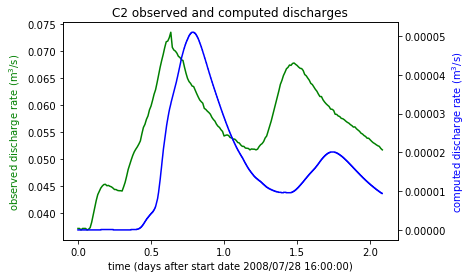

In [65]:
plot_discharge_comparison(output_path+run)

In [66]:
with open(output_path+run+'/Test1.log', 'r') as fin:
    print fin.read()

------------------------------------------------------------
TopoFlow Version 3.5 (2/20/17)
Mon Feb 27 11:05:07 2017
 
Input directory:      C2-input-files/\
Output directory:     simulation-outputs/max_infiltration_hr_d82s\
Site prefix:          C2
Case prefix:          Test1
 
Simulated time:      3000.0 [min]
Program run time:    19.5530166666 [min]
 
Number of timesteps: 90000
Number of columns:   233
Number of rows:      113
 
T_stop:            3000.0 [min]
 
Main outlet ID:    (101, 124) (row, col)
Basin_area:        4.83503 [km^2] 
 
Min Manning's n:   0.0131894815713
Max Manning's n:   0.300035893917
 
Q_final:           9.33339610863e-06 [m^3/s]
Q_peak:            5.10033333924e-05 [m^3/s]
Q_peak_time:       1131.4 [min]
u_peak:            0.0392618807978 [m/s]
u_peak_time:       1131.36666667 [min]
d_peak:            0.000200089558215 [m]
d_peak_time:       1131.36666667 [min]
 
Max(precip rate):  4.59000015259 [mm/hr]
 
Total accumulated volumes over entire DEM:
vol_P   (ra

For this run, we note that the infiltrated volume (vol_IN) is higher than the precipitated volume; this is most likely due to an error from the discretized, computational solution. We may retry doing this calculation with the more finely sampled precipitation file as previously to show a better matching between those two values. We see that essentially all of the volume is infiltrated.

### Run 3. Saturated soil, sweep Ks.

For this run, we start with completely saturated soil and observe the modulation effect of Ks on the peak responses. From the Green-Ampt equation, we expect this result to affect peaks independent of when they occur, as the f_c component is null (theta_i = theta_sat).

Again, take out comments below to run the model. (This run may take up to several hours.)

In [67]:
%%capture
run='Ks_sweep_at_saturation/'
runname = ['Ks5en7','Ks5p5en7','Ks6en7','Ks6p5en7','Ks7en7','Ks7p5en7','Ks8en7','Ks8p5en7']
create_path(output_path+run)
for x in range(8): #8 Ks runs with theta_i = theta_sat
    Ksat = 5.0*10**-7 + 0.5*x*10**-7
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components_hr:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=theta_sat,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

Now we plot the Ks sweep to see how Ks affects the discharge output.

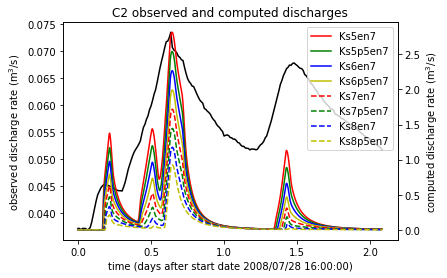

In [68]:
plot_discharge_comparison_multiple(output_path+run,runname)

We note that Ks alone has the greatest attenuation impact on the small peak of the peak B pair, and on peak C. This follows from the fact that, from the precipitation plot, these responses correspond to the two smallest precipitation peaks. To get a better look, let's zoom in on the first two peaks and note how the ratio of the height of peak A to the small peak of the peak B pair increases with increasing Ks. 

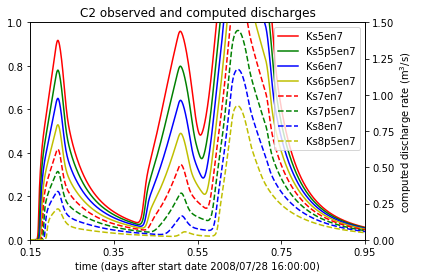

In [69]:
plot_discharge_comparison_multiple(output_path+run,runname,x_range=np.arange(0.15,1,0.2),y_range=np.arange(0,1.51,0.25))

The following lines generate the previous graphs with the same formatting as in the paper.

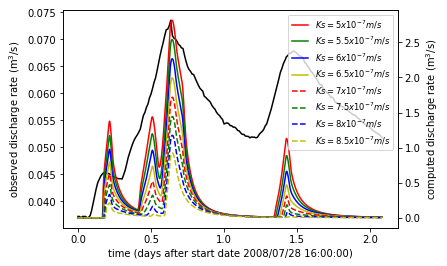

In [70]:
plot_discharge_comparison_multiple_eps(output_path+run,runname,'fig_Ks_effect.eps','} m/s')

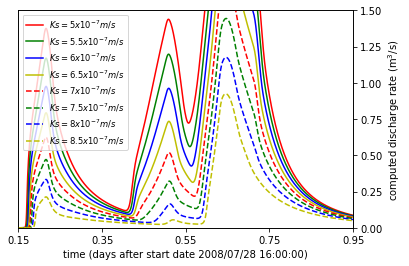

In [71]:
plot_discharge_comparison_multiple_eps(output_path+run,runname,'fig_Ks_effect_zoom.eps','} m/s',x_range=np.arange(0.15,1.1,0.2),y_range=np.arange(0,1.51,0.25))

### Run 4. Test the effect of G on peaks for constant Ks.

Now, let's do a sweep run testing the effect of G on the peaks. We expect that the first few peaks will be more affected, and that as we increase G, the effect will be more emphasized.

Again, take out commented lines below if you would like to run these simulations. The run may take up to 2 hours.

In [72]:
%%capture
run='G_sweep_for_peaks/'
Ksat = 7*10**-7 #m/s
runname = ['G0p012','G0p01','G0p008','G0p006','G0p004']
create_path(output_path+run)
for x in range(5): #5 runs with theta_i = 0.01
    G = 0.012 - 0.002*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components_hr:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.01,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

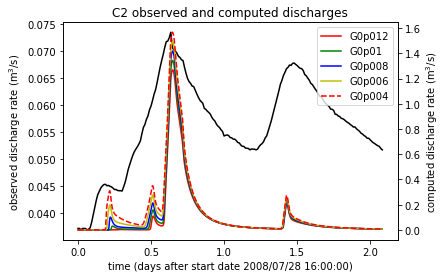

In [73]:
plot_discharge_comparison_multiple(output_path+run,runname)

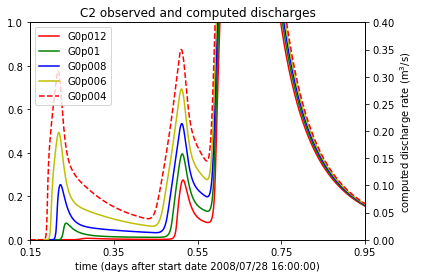

In [74]:
plot_discharge_comparison_multiple(output_path+run,runname,x_range=np.arange(0.15,1,0.2),y_range=np.arange(0,0.42,0.05))

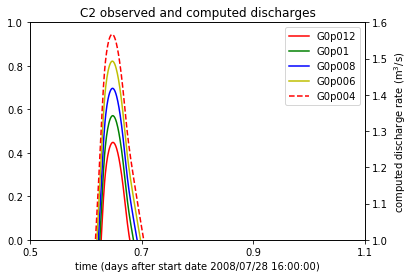

In [75]:
plot_discharge_comparison_multiple(output_path+run,runname,x_range=np.arange(0.5,1.1,0.2),y_range=np.arange(1,1.6,0.1))

The peaks comprising A and B are significantly affected by G, while the last peak is not.

In order to maximize infiltration while retaining the peaks, we try to keep theta_i small and increase G until the first two peaks start to disappear. This will give us the minimum volume discharge we can obtain with this Ks setting while retaining the peaks. This procedure yields us the optimum product G(theta_sat-theta_i)(1-(theta_i/theta_sat)^c). We may then adjust theta_i and G so that they are within a reasonable range.

The following lines generate the plots in the paper in eps format.

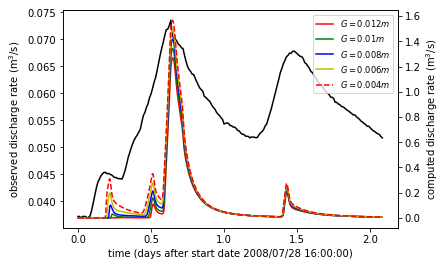

In [76]:
plot_discharge_comparison_multiple_eps(output_path+run,runname,'fig_G_effect.eps',' m')

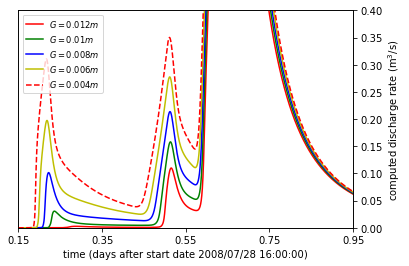

In [77]:
plot_discharge_comparison_multiple_eps(output_path+run,runname,'fig_G_effect_zoom.eps',' m',x_range=np.arange(0.15,1,0.2),y_range=np.arange(0,0.42,0.05))

### Run 5. Example of matching total volume discharge but not necessarily peaks.

In the following string of examples, we show how, by starting with an initial guess for Ks, we can adjust G and the drag factor (Manning n magnitude) to obtain a result that approaches the observed discharge.

In [78]:
%%capture
run='G_sweep_for_area/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p725','G0p675','G0p625','G0p575','G0p525']
create_path(output_path+run)
for x in range(5): #5 runs with theta_i = 0.17
    G = 0.725 - 0.05*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components_hr:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

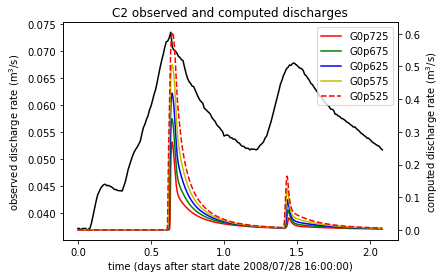

In [79]:
plot_discharge_comparison_multiple(output_path+run,runname)

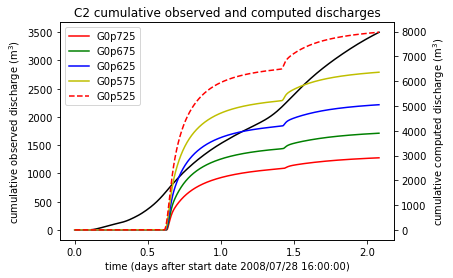

In [80]:
plot_total_discharge(output_path+run,runname)

For the following runs, a bit of manipulation of the raw code is needed. You will also need to close this notebook and restart it and reload topoflow so that changes can be reflected. To change the Manning n factor value, go to the topoflow/components folder and open the channels_base.py file. (You may also want to delete channels_base.pyc.) Edit line 2036 with the factor you wish to use:  
> nval = model_input.read_next(self.nval_unit, self.nval_type, rti,factor=30) 

In [81]:
%%capture
run='G_sweep_for_area/manning_n_factor_8/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p725_2']
create_path(output_path+run)
for x in range(1): #5 runs with theta_i = 0.17
    G = 0.725 - 0.05*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components_2s:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

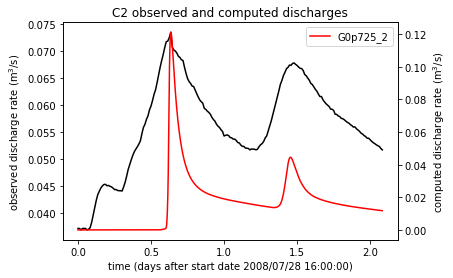

In [82]:
plot_discharge_comparison_multiple(output_path+run,runname)

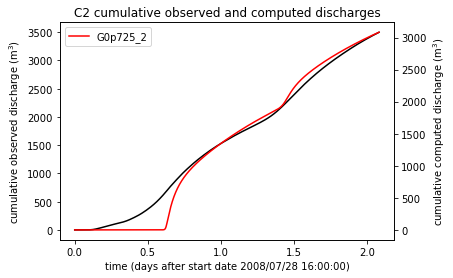

In [83]:
plot_total_discharge(output_path+run,runname)

In [99]:
%%capture
run='G_sweep_for_area/manning_n_factor_8/'
Ksat = 5.25*10**-7 #m/s
runname = ['Ks5p25en7G0p775_2']
create_path(output_path+run)
for x in range(1): #5 runs with theta_i = 0.17
    G = 0.775 - 0.05*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components_2s:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

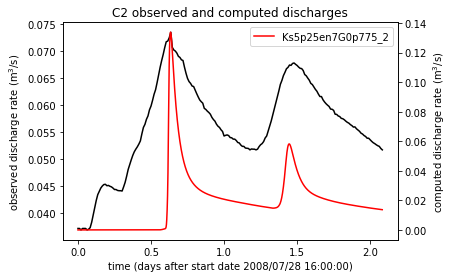

In [100]:
plot_discharge_comparison_multiple(output_path+run,runname)

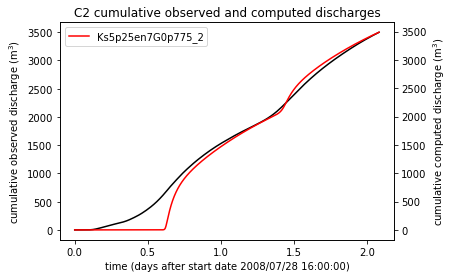

In [101]:
plot_total_discharge(output_path+run,runname)

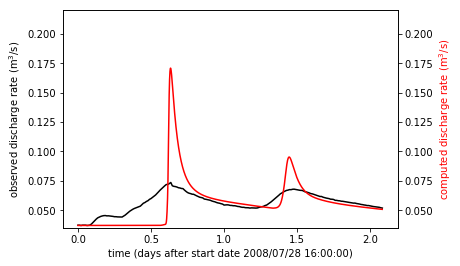

In [102]:
plot_discharge_comparison_multiple_eps2(output_path+run,runname,'fig_2peak_trial_best_result.eps')

In [93]:
%%capture
run='G_sweep_for_area/manning_n_factor_8/'
Ksat = 4.75*10**-7 #m/s
runname = ['Ks4p75en7G0p9_2']
create_path(output_path+run)
for x in range(1): #5 runs with theta_i = 0.17
    G = 0.9 - 0.05*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components_2s:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

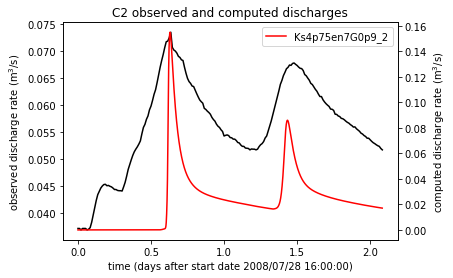

In [94]:
plot_discharge_comparison_multiple(output_path+run,runname)

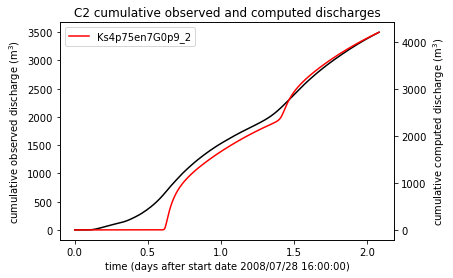

In [95]:
plot_total_discharge(output_path+run,runname)

In [103]:
%%capture 
run='G_sweep_for_area/manning_n_factor_6/'
Ksat = 4.5*10**-7 #m/s
runname = ['Ks4p5en7G1p1_2']
create_path(output_path+run)
for x in range(1): #5 runs with theta_i = 0.17
    G = 1.1 - 0.05*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components_2s:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

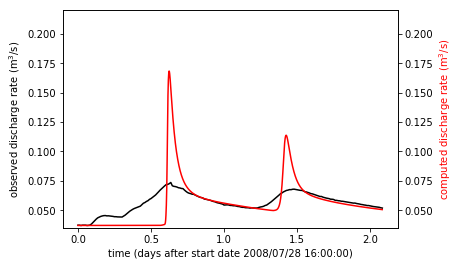

In [104]:
plot_discharge_comparison_multiple_eps2(output_path+run,runname,'fig_2peak_best_result_ver2.eps')

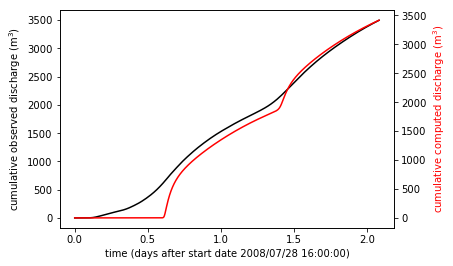

In [105]:
plot_total_discharge_eps(output_path+run,runname,'fig_2peak_best_result_vol.eps')

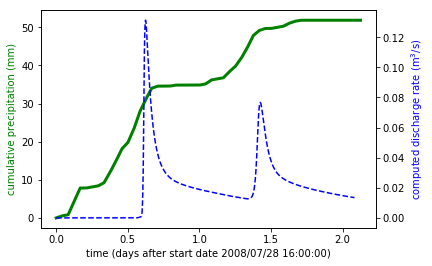

In [106]:
plot_cumulative_precip_discharge_comparison_eps(sub_run,'fig_discharge_response_to_cumulative_precip.eps')

In the last run we notice (a) the correct cummulative output, (b) tail end discharges that match the observed rates, and (c) slower, but more intense initial peak precipitation responses. This may suggest that the Manning n method does not correctly model to type of vegetation drag effect in the landscape.

### Run 6. Example of maintaining peaks while minimizing volume (with volume still large).

In [107]:
%%capture
run='maintaining_peaks_low_volume/'
Ksat = 7.9*10**-7 #m/s
runname = ['G0p005','G0p006']
create_path(output_path+run)
for x in range(2): #2 runs with theta_i = 0.01
    G = 0.005 + 0.001*x
    sub_run = output_path+run+runname[x]
    create_path(sub_run)
    for filename in base_components_hr:
        create_cfg(filename,sub_run)
    create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.01,G=G)
    #topo_run(cfg_prefix='Test1',cfg_directory=input_path)
    #post_run_cleanup(sub_run)

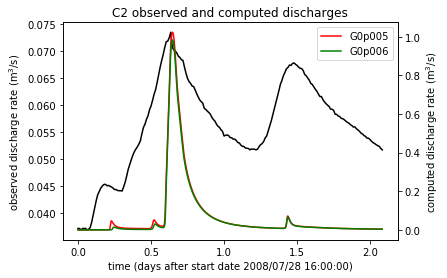

In [108]:
plot_discharge_comparison_multiple(output_path+run,runname)

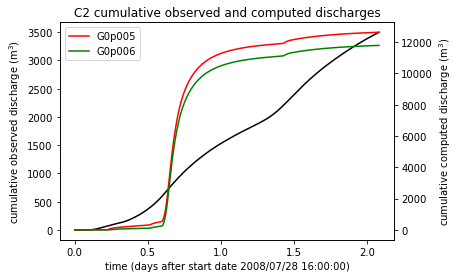

In [109]:
plot_total_discharge(output_path+run,runname)

### Run 7. Example of maintaining peaks, but volume is much larger than measured.

In [110]:
%%capture
run='maintaining_peaks_high_volume/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p1']
create_path(output_path+run)
G = 0.1
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components_hr:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

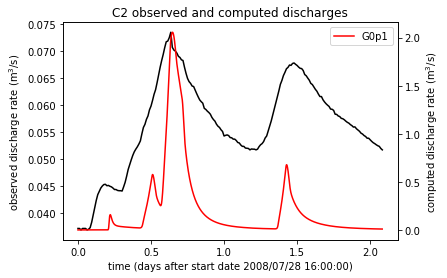

In [111]:
plot_discharge_comparison_multiple(output_path+run,runname)

In [112]:
%%capture
run='maintaining_peaks_high_volume/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p082']
create_path(output_path+run)
G = 0.082
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components_hr:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.18,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

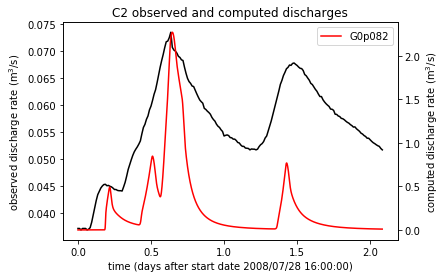

In [113]:
plot_discharge_comparison_multiple(output_path+run,runname)

### Run 8. Example effects of vegetation/surface drag.
For the following runs, the drag/roughness was increased by multiplying the Manning n grid by a factor. You will have to change the factor in the code before running, as described previously.

Drag factor = 5:

In [114]:
%%capture
run='maintaining_peaks_high_volume/drag_factor_5/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p1']
create_path(output_path+run)
G = 0.1
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components_2s:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

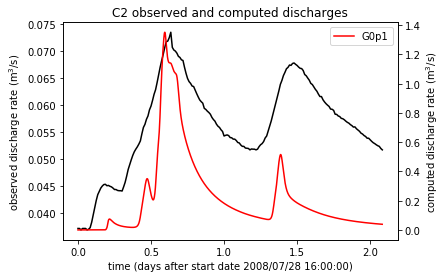

In [115]:
plot_discharge_comparison_multiple(output_path+run,runname)

In [116]:
%%capture
run='maintaining_peaks_high_volume/drag_factor_15/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p1']
create_path(output_path+run)
G = 0.1
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components_2s:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.17,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

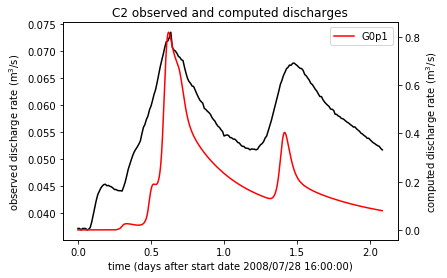

In [117]:
plot_discharge_comparison_multiple(output_path+run,runname)

In [118]:
%%capture
run='maintaining_peaks_high_volume/drag_factor_15/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p082']
create_path(output_path+run)
G = 0.082
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components_2s:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.18,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

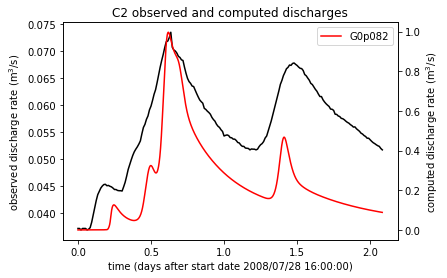

In [119]:
plot_discharge_comparison_multiple(output_path+run,runname)

In [120]:
%%capture
run='maintaining_peaks_high_volume/drag_factor_30/'
Ksat = 5.5*10**-7 #m/s
runname = ['G0p082']
create_path(output_path+run)
G = 0.082
sub_run = output_path+run+runname[0]
create_path(sub_run)
for filename in base_components_2s:
    create_cfg(filename,sub_run)
create_infil_cfg(infil_filename,sub_run,Ksat=Ksat,theta_i=0.18,G=G)
#topo_run(cfg_prefix='Test1',cfg_directory=input_path)
#post_run_cleanup(sub_run)

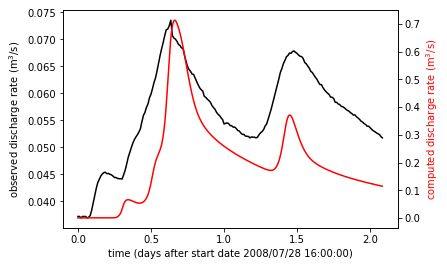

In [121]:
plot_discharge_comparison_multiple_eps(output_path+run,runname,'fig_all_peaks_increased_drag.eps','')

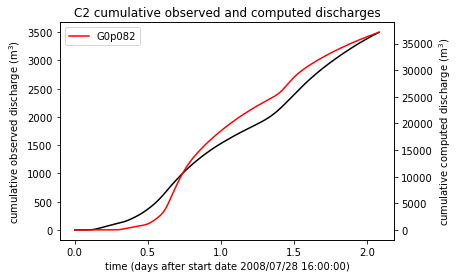

In [122]:
plot_total_discharge(output_path+run,runname)

Although the volume and timing are off, we note that increasing the drag gives us curves that much more closely resemble the observed output. The timing of the peaks is off because we have to increase the drag factor to extremely high values; this is necessitated by the high volumes. Therefore, we conclude that vegetation resistance may have a great impact on the character of the outflow. However, since the Manning n method only models the surface resistance, the model does not do well in simulating vegetation roughness for large volume flows.

There are many reasons why the simulations are not able to obtain simultaneously an accurate curve shape retaining all of the peaks and a correct volume. Among these reasons, the predominant factor is likely that precipitation data is sparse (collected hourly) and thus may not reflect the true oscillations of the precipitation, forcing us to model using lower Ks values than those of the real system.